# Interoperability

This notebook shows some way that you can import and export data from `spatialproteomics`.

In [1]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics as sp
import pandas as pd
import xarray as xr
import os
import shutil
import anndata

## Exporting Data

Once you are happy with your analysis, you will likely want to export the results. The easiest way to do this is by using the `zarr` format, but `csv`, `anndata`, and `spatialdata` are also supported.

In [2]:
# loading a test file which we will export later
# notice how easy it is to load the file from a zarr using xarray
ds = xr.open_zarr("../../tests/test_files/ds_neighborhoods.zarr")
ds

<xarray.Dataset> Size: 171kB
Dimensions:               (cells: 56, cells_2: 56, channels: 5, y: 101, x: 101,
                           la_features: 2, labels: 4, la_props: 2,
                           neighborhoods: 5, nh_props: 2, features: 6)
Coordinates:
  * cells                 (cells) int64 448B 1 2 3 4 5 6 7 ... 51 52 53 54 55 56
  * cells_2               (cells_2) int64 448B 1 2 3 4 5 6 ... 51 52 53 54 55 56
  * channels              (channels) <U11 220B 'DAPI' 'PAX5' 'CD3' 'CD4' 'CD8'
  * features              (features) <U14 336B 'CD4_binarized' ... 'centroid-1'
  * la_features           (la_features) object 16B 'labels_0' 'labels_1'
  * la_props              (la_props) <U6 48B '_color' '_name'
  * labels                (labels) int64 32B 1 2 3 4
  * neighborhoods         (neighborhoods) int64 40B 1 2 3 4 5
  * nh_props              (nh_props) <U6 48B '_color' '_name'
  * x                     (x) int64 808B 1600 1601 1602 1603 ... 1698 1699 1700
  * y                     (y) int64 808B 2100 2101 2102 2103 ... 2198 2199 2200
Data variables:
    _adjacency_matrix     (cells, cells_2) int64 25kB dask.array<chunksize=(56, 56), meta=np.ndarray>
    _image                (channels, y, x) uint8 51kB dask.array<chunksize=(5, 101, 101), meta=np.ndarray>
    _intensity            (cells, channels) float64 2kB dask.array<chunksize=(56, 5), meta=np.ndarray>
    _la_layers            (cells, la_features) object 896B dask.array<chunksize=(56, 2), meta=np.ndarray>
    _la_properties        (labels, la_props) object 64B dask.array<chunksize=(4, 2), meta=np.ndarray>
    _neighborhoods        (cells, labels) float64 2kB dask.array<chunksize=(56, 4), meta=np.ndarray>
    _nh_properties        (neighborhoods, nh_props) <U14 560B dask.array<chunksize=(5, 2), meta=np.ndarray>
    _obs                  (cells, features) float64 3kB dask.array<chunksize=(56, 6), meta=np.ndarray>
    _percentage_positive  (cells, channels) float64 2kB dask.array<chunksize=(56, 5), meta=np.ndarray>
    _segmentation         (y, x) int64 82kB dask.array<chunksize=(101, 101), meta=np.ndarray>

## Exporting to Zarr
This is the easiest file format to work with. It allows you to store and load the xarray objects with a single line of code. It is highly recommended to call `drop_encoding()` before exporting to zarr. There are several open issues linked to encoding problems, and this is the easiest way to circumvent them. For more references, refer to these issues: [issue 1](https://github.com/pydata/xarray/issues/3476), [issue 2](https://github.com/pydata/xarray/issues/9037).

In [3]:
zarr_path = "tmp.zarr"

# removing the zarr if it exists
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

# exporting as zarr
ds.drop_encoding().to_zarr("tmp.zarr")

## Exporting Tables to CSV
Let's say you want to export some tables as csvs. This can be done with pandas.

In [5]:
df = ds.pp.get_layer_as_df("_obs")
df.head()

,CD4_binarized,CD8_binarized,_labels,_neighborhoods,centroid-0,centroid-1
1,0.0,0.0,B,Neighborhood 1,2103.768519,1607.277778
2,0.0,1.0,T_tox,Neighborhood 1,2103.857143,1630.741071
3,1.0,1.0,T_h,Neighborhood 3,2104.837037,1668.733333
4,0.0,1.0,T_tox,Neighborhood 3,2101.750000,1677.000000
5,0.0,1.0,B,Neighborhood 3,2104.416058,1685.627737


In [6]:
# exporting as csv
df.to_csv("tmp.csv")

## Exporting to AnnData
AnnData is a format used by scanpy, which can be useful to create interesting plots and downstream analyses. For this reason, you can export the xarray object as an AnnData object. Note that this object will only store the tabular data, but not the image or the segmentation layer.

In [9]:
# putting the expression matrix into an anndata object
adata = ds.tl.convert_to_anndata(
    expression_matrix_key="_intensity",
    additional_layers={"percentage_positive": "_percentage_positive"},
    additional_uns={"label_colors": "_la_properties"},
)
adata

AnnData object with n_obs × n_vars = 56 × 5
    obs: 'CD4_binarized', 'CD8_binarized', '_labels', '_neighborhoods', 'centroid-0', 'centroid-1'
    uns: '_labels_colors', 'label_colors'
    obsm: 'spatial'
    layers: 'percentage_positive'

In [10]:
# writing to disk as hdf5
adata.write("tmp.h5ad")

... storing '_labels' as categorical
... storing '_neighborhoods' as categorical


## Exporting to SpatialData
SpatialData is a data format which is commonly used for spatial omics analysis and combines the power of zarr with anndata. You can export to this data format as well.

In [11]:
spatialdata_object = ds.tl.convert_to_spatialdata(expression_matrix_key="_intensity")
spatialdata_object

/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('y', 'x').                                


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (5, 101, 101)
├── Labels
│     └── 'segmentation': DataArray[yx] (101, 101)
└── Tables
      └── 'table': AnnData (56, 5)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), segmentation (Labels)

In [12]:
# storing as zarr file
spatialdata_object.write("tmp.zarr")

INFO     The Zarr backing store has been changed from None the new file path: tmp.zarr                             


## Importing from Spatialdata

In the example workflow, you have already seen how to read data from a tiff file. If you already have your data in `spatialdata` format, you can also read it in from there. Reading in the data like this will convert the data from `spatialdata` format to `xarray` format, so that you can use the `xarray` backend of `spatialproteomics`.

In [13]:
ds = sp.read_from_spatialdata("../../data/spatialdata_example.zarr", image_key="raccoon")
ds

root_attr: multiscales
root_attr: omero
datasets [{'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0], 'type': 'scale'}], 'path': '0'}]
/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
resolution: 0
 - shape ('c', 'y', 'x') = (3, 768, 1024)
 - chunks =  ['3', '768', '1024']
 - dtype = uint8
root_attr: multiscales
root_attr: omero
Unsupported transform Identity , resetting coordinates for the spatialproteomics object.


<xarray.Dataset> Size: 9MB
Dimensions:        (channels: 3, y: 768, x: 1024, cells: 70, features: 2)
Coordinates:
  * channels       (channels) int64 24B 0 1 2
  * y              (y) int64 6kB 0 1 2 3 4 5 6 7 ... 761 762 763 764 765 766 767
  * x              (x) int64 8kB 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * cells          (cells) int64 560B 1 2 3 4 5 6 7 8 ... 64 65 66 67 68 69 70
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 2MB dask.array<chunksize=(3, 768, 1024), meta=np.ndarray>
    _segmentation  (y, x) int64 6MB 0 0 0 0 0 0 0 0 ... 69 69 69 69 69 69 69 69
    _obs           (cells, features) float64 1kB 44.79 402.5 ... 736.5 890.5

## Exporting to Seurat

`Seurat` is widely used in the R community to analyze spatial omics data. Here, we show how you can create a `Seurat` object from a `spatialproteomics` one. It is most sensible to store the data frame to disk first, and then read it in with R. For demonstration purposes, we run R directly in this notebook.

In [1]:
# setup and data loading
import os
import sys

# setup for rpy2 to use the correct R binary
env_r_bin = "/g/huber/users/meyerben/.conda/envs/tmp_env_3/bin"
os.environ["PATH"] = env_r_bin + os.pathsep + os.environ.get("PATH", "")
if "R_HOME" in os.environ:
    del os.environ["R_HOME"]

%load_ext rpy2.ipython

import xarray as xr
import spatialproteomics as sp

celltype_colors = {
    "B cell": "#5799d1",
    "T cell": "#ebc850",
    "Myeloid cell": "#de6866",
    "Dendritic cell": "#4cbcbd",
    "Macrophage": "#bb7cb4",
    "Stromal cell": "#62b346",
    "Endothelial cell": "#bf997d",
}

# loading in a data set
ds = xr.open_zarr("../../data/LN_24_1.zarr")
# for clearer visualizations, we set the cell types to the broadest level (B cells, T cells, ...)
ds = ds.la.set_label_level("labels_0", ignore_neighborhoods=True).la.set_label_colors(
    celltype_colors.keys(), celltype_colors.values()
)

In [2]:
# this gives us a data frame of cells by markers
intensity_df = ds.pp.get_layer_as_df("_intensity")

# getting the spatial information and cell types from the spatialproteomics object
spatial_df = ds.pp.get_layer_as_df()[["centroid-0", "centroid-1", "_labels"]]
# renaming the columns for better compatibility with R
spatial_df.columns = ["centroid.0", "centroid.1", "labels"]

In [3]:
# send the data to R, so that we can use it directly
%R -i intensity_df
%R -i spatial_df

In [4]:
%%R
library(Seurat)
library(dplyr)

# intensity_df: each row = cell, each col = marker
# transpose so markers become "genes"
mat <- t(as.matrix(intensity_df))

# Make sure row/col names align
colnames(mat) <- rownames(intensity_df)

# Create Seurat object
seu <- CreateSeuratObject(counts = mat)

# Add metadata (spatial info + cell labels)
seu <- AddMetaData(seu, metadata = spatial_df)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built with package ‘Matrix’ 1.7.3 but the current
version is 1.7.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
%%R
# Make sure the rownames exactly match the Seurat cells
spatial_coords <- spatial_df[, c("centroid.0", "centroid.1")]

# The cell names in the Seurat object
cell_names <- Cells(seu)

# Assign rownames
rownames(spatial_coords) <- cell_names
colnames(spatial_coords) <- c(1, 2)

# Convert to matrix
embeddings_mat <- as.matrix(spatial_coords)

# Now create the spatial reduction
seu[["spatial"]] <- CreateDimReducObject(
  embeddings = embeddings_mat,
  key = "spatial_",
  assay = DefaultAssay(seu)
)

Learn more about the underlying theory at https://ggplot2-book.org/


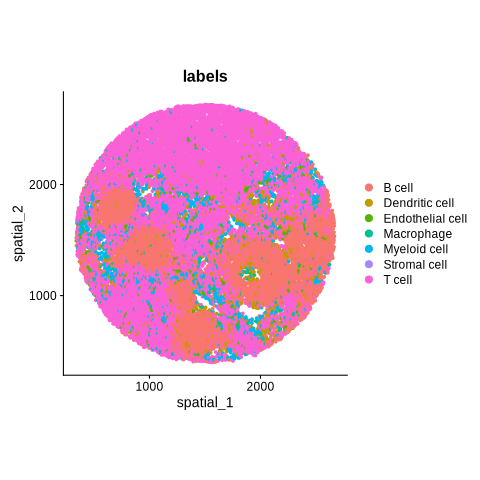

In [7]:
%%R
library(ggplot2)

p <- DimPlot(
  seu,
  reduction = "spatial",
  group.by = "labels",
  pt.size = 1
) + coord_fixed()  # ensures x and y axes have equal scale

print(p)